In [1]:
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import random
import scipy
from scipy import stats

In [2]:
DATA_PATH = 'data/'

In [3]:
df = pd.read_pickle(DATA_PATH + "data.pkl")

In [4]:
df.head()

,Weight,Image Timestamp,Time Offset,Participant,ImageSum,BlobImages,BlobW,BlobH,BlobArea,BlobSum,Noise,Version,Set
13,2,1.528834e+12,34.0,1,1917,"[[2.0, 2.0, 9.0, 7.0, 2.0, 0.0, 0.0, 0.0, 0.0,...",3,3,9,1072,0,Normal,Test
14,23,1.528834e+12,50.0,1,2096,"[[0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,4,12,1171,0,Normal,Test
15,126,1.528834e+12,43.0,1,1661,"[[0.0, 0.0, 1.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",4,4,16,1305,0,Normal,Test
16,231,1.528834e+12,12.0,1,1465,"[[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,4,16,1321,0,Normal,Test
17,308,1.528834e+12,37.0,1,1465,"[[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,4,16,1321,0,Normal,Test


In [5]:
import skimage
from skimage import measure
from skimage.measure import find_contours, approximate_polygon, \
    subdivide_polygon, EllipseModel, LineModelND
from matplotlib.patches import Ellipse
import math

def getEllipseParams(img):
    points = np.argwhere(img > 40)
    
    contours = skimage.measure.find_contours(img, 40)
    points_to_approx = []
    highest_val = 0
    for n, contour in enumerate(contours):
        if (len(contour) > highest_val):
            points_to_approx = contour
            highest_val = len(contour)   
    
    try:
        contour = np.fliplr(points_to_approx)
    except Exception as inst:
        return [-1, -1, -1, -1, -1]
    

    ellipse = skimage.measure.fit.EllipseModel()
    ellipse.estimate(contour)
    try:
        xc, yc, a, b, theta = ellipse.params  
    except Exception as int:
        return [-1, -1, -1, -1, -1]
    
    return [xc, yc, a, b, theta]

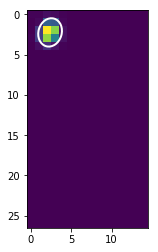

In [6]:
fig, ax = plt.subplots(1)
img = df.iloc[0].BlobImages
xc, yc, a, b, theta = getEllipseParams(img)
ax.imshow(img)
e = Ellipse(xy=[xc,yc], width=a*2, height=b*2, angle=math.degrees(theta), fill=False, lw=2, edgecolor='w')
ax.add_artist(e)

In [7]:
%%time
lst = df.BlobImages.apply(lambda x: getEllipseParams(x))
lst2 = np.vstack(lst.values)

CPU times: user 14min 5s, sys: 6min 2s, total: 20min 8s
Wall time: 6min 43s


In [8]:
df["XC"] = lst2[:,0]
df["YC"] = lst2[:,1]
df["EllipseW"] = lst2[:,2]
df["EllipseH"] = lst2[:,3]
df["EllipseTheta"] = lst2[:,4]
df["Area"] = df["EllipseW"] * df["EllipseH"] * np.pi
df["AvgCapa"] = df.BlobImages.apply(lambda x: np.mean(x))
df["SumCapa"] = df.BlobImages.apply(lambda x: np.sum(x))

In [9]:
features = ["SumCapa", "AvgCapa", "Area", "EllipseW", "EllipseH", "EllipseTheta"]

In [10]:
len(df[df.Set== "Test"]) / len(df[df.Set== "Train"])

0.2606082434774779

In [11]:
len(df[(df.Set== "Test") & (df.Version == "Normal") & (df.Noise == 0)])

16781

In [12]:
bins = 25
df["Bin"] = (df.Weight / bins).round().astype(int)
u = sorted(df["Bin"].unique())
u= np.array(u)*bins

In [13]:
dfX = df[(df.Version == "Normal") & (df.Noise == 0)]

In [14]:
dfX = dfX.sort_values("Weight")

In [ ]:
scipy.stats.pearsonr(dfX.Area.values, dfX.Weight.values)

(0.22236917760202618, 0.0)

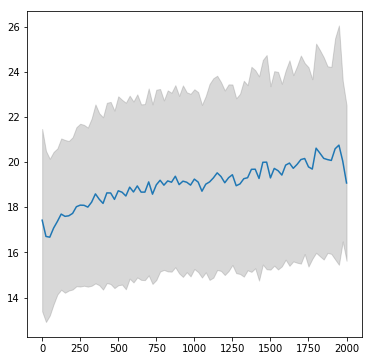

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
mean = dfX.groupby(["Bin"]).BlobArea.mean()
std = dfX.groupby(["Bin"]).BlobArea.std()
lUpper = mean + std
lLower = mean - std
ax.fill_between(u, lUpper.values, lLower.values, color='gray', alpha=0.3)
plt.plot(u, dfX.groupby(["Bin"]).BlobArea.mean(), label="Train")

In [ ]:
import sklearn
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
dfY = df[df.Set == "Train"]
dfT = dfX[dfX.Set == "Test"].copy(deep=True)

In [19]:
%%time
param_grid = {'n_neighbors': range(3,12,1)}
clf = GridSearchCV(neighbors.KNeighborsRegressor(), 
                   param_grid,
                   scoring="neg_mean_squared_error",
                   cv=5 , n_jobs=28, verbose=1)
clf.fit(dfY[features].values, dfY.Weight.values)
print(clf.best_params_, clf.best_score_)
dfT["WeightPred"] = clf.predict(dfT[features].values)
dfT["Error"] = dfT.Weight - dfT.WeightPred
dfT["ErrorAbs"] = dfT.Error.abs()
rmse = np.sqrt(mean_squared_error(dfT.Weight, dfT.WeightPred))
print("$\\textit{RMSE} = %.2fg$" % rmse)
print("$\\textit{MAE} = %.2fg$ ($\\textit{SD}= %.2fg$)" % (dfT.ErrorAbs.mean(), dfT.ErrorAbs.std()))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done  36 out of  45 | elapsed:   21.0s remaining:    5.2s
[Parallel(n_jobs=28)]: Done  45 out of  45 | elapsed:   23.0s finished


{'n_neighbors': 6} -262694.8671374563
$\textit{RMSE} = 659.02g$
$\textit{MAE} = 534.56g$ ($	extit{SD}= 385.45g$)
CPU times: user 1.89 s, sys: 2.46 s, total: 4.35 s
Wall time: 24.8 s


In [28]:
%%time
param_grid = {'max_depth': range(15,20,1),
              'min_samples_split': range(14,23,1)}
clf = GridSearchCV(tree.DecisionTreeRegressor(), 
                   param_grid,
                   scoring="neg_mean_squared_error",
                   cv=5 , n_jobs=30, verbose=1)
clf.fit(dfY[features].values, dfY.Weight.values)
print(clf.best_params_, clf.best_score_)
dfT["WeightPred"] = clf.predict(dfT[features].values) 
dfT["Error"] = dfT.Weight - dfT.WeightPred
dfT["ErrorAbs"] = dfT.Error.abs()
rmse = np.sqrt(mean_squared_error(dfT.Weight, dfT.WeightPred))
print("$\\textit{RMSE} = %.2fg$" % rmse)
print("$\\textit{MAE} = %.2fg$ ($\\textit{SD}= %.2fg$)" % (dfT.ErrorAbs.mean(), dfT.ErrorAbs.std()))

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:  1.2min
[Parallel(n_jobs=30)]: Done 225 out of 225 | elapsed:  1.8min finished


{'max_depth': 18, 'min_samples_split': 22} -252459.6333146262
$\textit{RMSE} = 611.58g$
$\textit{MAE} = 492.70g$ ($\textit{SD}= 362.33g$)
CPU times: user 9.43 s, sys: 2.86 s, total: 12.3 s
Wall time: 1min 56s


In [29]:
%%time
param_grid = {'n_estimators': range(2,16,2)}
clf = GridSearchCV(ensemble.RandomForestRegressor(), 
                   param_grid,
                   scoring="neg_mean_squared_error",
                   cv=5 , n_jobs=30, verbose=1)
clf.fit(dfY[features].values, dfY.Weight.values)
print(clf.best_params_, clf.best_score_)
dfT["WeightPred"] = clf.predict(dfT[features].values) 
dfT["Error"] = dfT.Weight - dfT.WeightPred
dfT["ErrorAbs"] = dfT.Error.abs()
rmse = np.sqrt(mean_squared_error(dfT.Weight, dfT.WeightPred))
print("$\\textit{RMSE} = %.2fg$" % rmse)
print("$\\textit{MAE} = %.2fg$ ($\\textit{SD}= %.2fg$)" % (dfT.ErrorAbs.mean(), dfT.ErrorAbs.std()))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  12 out of  35 | elapsed:  1.1min remaining:  2.1min
[Parallel(n_jobs=30)]: Done  35 out of  35 | elapsed:  2.5min finished


{'n_estimators': 14} -190707.93995566102
$\textit{RMSE} = 583.36g$
$\textit{MAE} = 470.51g$ ($\textit{SD}= 344.88g$)
CPU times: user 1min 46s, sys: 451 ms, total: 1min 46s
Wall time: 4min 13s


In [25]:
%%time
param_grid = [{'kernel': ['rbf'],  'C': [1, 10, 100, 1000]}] #'gamma': [1e-3, 1e-4],
                    #{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(svm.SVR(), 
                   param_grid,
                   scoring="neg_mean_squared_error",
                   cv=5 , n_jobs=30, verbose=1)
clf.fit(dfY[features].values, dfY.Weight.values)
print(clf.best_params_, clf.best_score_)
dfT["WeightPred"] = clf.predict(dfT[features].values)  
dfT["Error"] = dfT.Weight - dfT.WeightPred
dfT["ErrorAbs"] = dfT.Error.abs()
rmse = np.sqrt(mean_squared_error(dfT.Weight, dfT.WeightPred))
print("$\\textit{RMSE} = %.2fg$" % rmse)
print("$\\textit{MAE} = %.2fg$ ($\\textit{SD}= %.2fg$)" % (dfT.ErrorAbs.mean(), dfT.ErrorAbs.std()))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   3 out of  20 | elapsed: 1026.9min remaining: 5819.0min
[Parallel(n_jobs=30)]: Done  20 out of  20 | elapsed: 3458.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{'C': 1000, 'kernel': 'rbf'} -285495.8687111031
$\textit{RMSE} = 648.25g$
$\textit{MAE} = 525.54g$ ($\textit{SD}= 379.53g$)
CPU times: user 2d 9h 8min 38s, sys: 10min 46s, total: 2d 9h 19min 25s
Wall time: 4d 18h 57min 42s


In [ ]:
%%time
param_grid = [{'kernel': ['rbf'],  'C': [10000, 100000, 1000000]}] #'gamma': [1e-3, 1e-4],
                    #{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(svm.SVR(), 
                   param_grid,
                   scoring="neg_mean_squared_error",
                   cv=5 , n_jobs=30, verbose=1)
clf.fit(dfY[features].values, dfY.Weight.values)
print(clf.best_params_, clf.best_score_)
dfT["WeightPred"] = clf.predict(dfT[features].values)  
dfT["Error"] = dfT.Weight - dfT.WeightPred
dfT["ErrorAbs"] = dfT.Error.abs()
rmse = np.sqrt(mean_squared_error(dfT.Weight, dfT.WeightPred))
print("$\\textit{RMSE} = %.2fg$" % rmse)
print("$\\textit{MAE} = %.2fg$ ($\\textit{SD}= %.2fg$)" % (dfT.ErrorAbs.mean(), dfT.ErrorAbs.std()))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


In [20]:
%%time
neigh = sklearn.svm.LinearSVR()
neigh.fit(dfY.BlobArea.values.reshape(-1,1), dfY.Weight.values) 
dfT["WeightPred"] = neigh.predict(dfT.BlobArea.values.reshape(-1,1)) 
dfT["Error"] = dfT.Weight - dfT.WeightPred
dfT["ErrorAbs"] = dfT.Error.abs()
rmse = np.sqrt(mean_squared_error(dfT.Weight, dfT.WeightPred))
print("$\\textit{RMSE} = %.2fg$" % rmse)
print("$\\textit{MAE} = %.2fg$ ($\\textit{SD}= %.2fg$)" % (dfT.ErrorAbs.mean(), dfT.ErrorAbs.std()))


$\textit{RMSE} = 593.51g$
$\textit{MAE} = 512.86g$ ($\textit{SD}= 298.72g$)
CPU times: user 3.26 s, sys: 381 ms, total: 3.64 s
Wall time: 3.03 s
